In [1]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
# Transformations, same as the ViT training scripts if without autoaug policy
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [3]:
# Load train set
train_set = dsets.CIFAR10('../data', train=True, download=True, transform=transform_train)

# Load test set (using as validation)
val_set = dsets.CIFAR10('../data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


# train vit model on cifar-10

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os.path
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

In [5]:
from copy import deepcopy

In [7]:
# Select device
device = torch.device('cuda:0')

### load trained vit classifier (pretrained in MAE)

we just need to load the model here

In [4]:
from model import *

In [5]:
model_path = './models/vit-t-classifier-from_pretrained_mae.pt'

In [8]:
print("Loading saved model")
model = torch.load(model_path).to(device)

Loading saved model


SAME as the resnet model, ViT model outputs unnormalized logits (scores) for each class, which serve as inputs to the Cross Entropy Loss

In [19]:
# torch.save(model.cpu(), model_path)

# train surrogates

In [23]:
from vit import ViT

In [9]:
from resnet import ResNet18

Using ViT (same as before) as the surrogate

In [10]:
from fastshap import ImageSurrogate
from fastshap.utils import MaskLayer2d, DatasetInputOnly, KLDivLoss

In [11]:
surr_model_path = './models/cifar_c10_vit_classifier_mae_surrogate_resnet.pt'

In [34]:
surr_model_path = './models/cifar_c10_vit_classifier_mae_surrogate.pt'

In [44]:
surr_model_path = './models/cifar_c10_vit_dim192+768_classifier_mae_surrogate.pt'
# change the mlp_hidden in surrogate model to 192 + 768

In [14]:
# Check for model
if os.path.isfile(surr_model_path):
    print('Loading saved surrogate model')
    surr = torch.load(surr_model_path).to(device)
    surrogate = ImageSurrogate(surr, width=32, height=32, superpixel_size=2)
else:
    print("Creating new surrogate model")
#     surr = nn.Sequential(
#         MaskLayer2d(value=0, append=True),
#         ViT(in_c = 4, num_classes=10, img_size=32, patch=8, dropout=0.0, num_layers=7,
#         hidden=192, mlp_hidden=768, head=12, is_cls_token=True)).to(device)
    surr = nn.Sequential(
        MaskLayer2d(value=0, append=True),
        ResNet18(in_channels=4, num_classes=10)).to(device)
    # Set up surrogate object
    surrogate = ImageSurrogate(surr, width=32, height=32, superpixel_size=2)

Creating new surrogate model


In [46]:
# to retrain just go from here 
# print("Creating new surrogate model")
# surr = nn.Sequential(
#     MaskLayer2d(value=0, append=True),
#     ViT(in_c = 4, num_classes=10, img_size=32, patch=8, dropout=0.0, num_layers=7,
#     hidden=384, mlp_hidden=384, head=12, is_cls_token=True)).to(device)
# # Set up surrogate object
# surrogate = ImageSurrogate(surr, width=32, height=32, superpixel_size=2)

In [15]:
# Set up datasets
train_surr = DatasetInputOnly(train_set)
val_surr = DatasetInputOnly(val_set)
original_model = nn.Sequential(model, nn.Softmax(dim=1)).to(device)

In [16]:
# Train
surrogate.train_original_model(
    train_surr,
    val_surr,
    original_model,
    batch_size=256,
    max_epochs=100,
    loss_fn=KLDivLoss(),
    lookback=20, #10
    bar=True,
    verbose=True)

Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 1 -----
Val loss = 1.5977

New best epoch, loss = 1.5977



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 2 -----
Val loss = 1.5098

New best epoch, loss = 1.5098



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 3 -----
Val loss = 1.3340

New best epoch, loss = 1.3340



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 4 -----
Val loss = 1.1506

New best epoch, loss = 1.1506



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 5 -----
Val loss = 1.0708

New best epoch, loss = 1.0708



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 6 -----
Val loss = 1.0284

New best epoch, loss = 1.0284



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 7 -----
Val loss = 0.9860

New best epoch, loss = 0.9860



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 8 -----
Val loss = 0.8763

New best epoch, loss = 0.8763



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 9 -----
Val loss = 0.8234

New best epoch, loss = 0.8234



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 10 -----
Val loss = 0.7930

New best epoch, loss = 0.7930



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 11 -----
Val loss = 0.9196



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 12 -----
Val loss = 0.8062



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 13 -----
Val loss = 0.7298

New best epoch, loss = 0.7298



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 14 -----
Val loss = 0.7339



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 15 -----
Val loss = 0.7409



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 16 -----
Val loss = 0.7167

New best epoch, loss = 0.7167



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 17 -----
Val loss = 0.6479

New best epoch, loss = 0.6479



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 18 -----
Val loss = 0.6635



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 19 -----
Val loss = 0.6850



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 20 -----
Val loss = 0.6742



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 21 -----
Val loss = 0.6140

New best epoch, loss = 0.6140



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 22 -----
Val loss = 0.6143



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 23 -----
Val loss = 0.5990

New best epoch, loss = 0.5990



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 24 -----
Val loss = 0.6169



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 25 -----
Val loss = 0.6095



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 26 -----
Val loss = 0.6209



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 27 -----
Val loss = 0.6541



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 28 -----
Val loss = 0.6347



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 29 -----
Val loss = 0.5979

New best epoch, loss = 0.5979



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 30 -----
Val loss = 0.5884

New best epoch, loss = 0.5884



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 31 -----
Val loss = 0.6050



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 32 -----
Val loss = 0.6091



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 33 -----
Val loss = 0.5876

New best epoch, loss = 0.5876



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 34 -----
Val loss = 0.6206



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 35 -----
Val loss = 0.6030



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 36 -----
Val loss = 0.5786

New best epoch, loss = 0.5786



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 37 -----
Val loss = 0.6058



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 38 -----
Val loss = 0.6130



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 39 -----
Val loss = 0.5889



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 40 -----
Val loss = 0.5780

New best epoch, loss = 0.5780



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 41 -----
Val loss = 0.6169



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 42 -----
Val loss = 0.5665

New best epoch, loss = 0.5665



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 43 -----
Val loss = 0.5880



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 44 -----
Val loss = 0.5677



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 45 -----
Val loss = 0.6113



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 46 -----
Val loss = 0.5869



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 47 -----
Val loss = 0.6399



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 48 -----
Val loss = 0.5967



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 49 -----
Val loss = 0.5910



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 50 -----
Val loss = 0.6058



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 51 -----
Val loss = 0.5969



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 52 -----
Val loss = 0.5793



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 53 -----
Val loss = 0.6175

Epoch    53: reducing learning rate of group 0 to 5.0000e-04.


Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 54 -----
Val loss = 0.5601

New best epoch, loss = 0.5601



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 55 -----
Val loss = 0.5706



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 56 -----
Val loss = 0.5715



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 57 -----
Val loss = 0.5957



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 58 -----
Val loss = 0.5764



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 59 -----
Val loss = 0.5913



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 60 -----
Val loss = 0.5829



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 61 -----
Val loss = 0.5646



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 62 -----
Val loss = 0.6037



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 63 -----
Val loss = 0.5970



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 64 -----
Val loss = 0.5824



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 65 -----
Val loss = 0.6025

Epoch    65: reducing learning rate of group 0 to 2.5000e-04.


Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 66 -----
Val loss = 0.5812



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 67 -----
Val loss = 0.5870



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 68 -----
Val loss = 0.5856



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 69 -----
Val loss = 0.6065



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 70 -----
Val loss = 0.5852



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 71 -----
Val loss = 0.5778



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 72 -----
Val loss = 0.5989



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 73 -----
Val loss = 0.5985



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 74 -----
Val loss = 0.6129

Stopping early


In [17]:
# surr.cpu()
# torch.save(surr, 'cifar_c10_vit_surrogate_lb20.pt') # lookback 20, best val loss 0.7623
torch.save(surr.cpu(), surr_model_path) # lookback 20, best val loss, best vak kiss 0.5698
# ls 0.827

In [54]:
next(surr.parameters()).device

device(type='cpu')

In [55]:
# TODO: train fastshap for this

# train fastshap

In [18]:
from unet import UNet
from fastshap import FastSHAP

In [19]:
# surr_model_path = './models/cifar_c10_vit_classifier_mae_surrogate.pt'
# surr = torch.load(surr_model_path).to(device)

In [20]:
surrogate = ImageSurrogate(surr.to(device), width=32, height=32, superpixel_size=2)

In [21]:
explainer_path = './models/cifar_c10_vit_classifier_mae_surr_resnet_explainer.pt'

In [22]:
# Check for model
if os.path.isfile(explainer_path):
    print('Loading saved explainer model')
    explainer = torch.load(explainer_path).to(device)
    fastshap = FastSHAP(explainer, surrogate, link=nn.LogSoftmax(dim=1))

else:
    # Set up explainer model
    explainer = UNet(n_classes=10, num_down=2, num_up=1, num_convs=3).to(device)

    # Set up FastSHAP object
    fastshap = FastSHAP(explainer, surrogate, link=nn.LogSoftmax(dim=1))

    # Set up datasets
    fastshap_train = DatasetInputOnly(train_set)
    fastshap_val = DatasetInputOnly(val_set)

    # Train
    fastshap.train(
        fastshap_train,
        fastshap_val,
        batch_size=128,
        num_samples=2,
        max_epochs=200,
        eff_lambda=1e-2,
        validation_samples=1,
        lookback=10,
        bar=True,
        verbose=True)
    
    # Save explainer
    explainer.cpu()
    torch.save(explainer, explainer_path)
    explainer.to(device)

Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 1 -----
Val loss = 15763.588867

New best epoch, loss = 15763.588867



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 2 -----
Val loss = 14449.174805

New best epoch, loss = 14449.174805



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 3 -----
Val loss = 12304.170898

New best epoch, loss = 12304.170898



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 4 -----
Val loss = 12008.557617

New best epoch, loss = 12008.557617



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 5 -----
Val loss = 10548.243164

New best epoch, loss = 10548.243164



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 6 -----
Val loss = 9901.740234

New best epoch, loss = 9901.740234



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 7 -----
Val loss = 11069.313477



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 8 -----
Val loss = 9493.915039

New best epoch, loss = 9493.915039



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 9 -----
Val loss = 9203.980469

New best epoch, loss = 9203.980469



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 10 -----
Val loss = 9241.747070



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 11 -----
Val loss = 9240.611328



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 12 -----
Val loss = 8437.528320

New best epoch, loss = 8437.528320



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 13 -----
Val loss = 8558.081055



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 14 -----
Val loss = 8343.234375

New best epoch, loss = 8343.234375



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 15 -----
Val loss = 8318.791992

New best epoch, loss = 8318.791992



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 16 -----
Val loss = 7829.751953

New best epoch, loss = 7829.751953



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 17 -----
Val loss = 8458.331055



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 18 -----
Val loss = 8265.835938



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 19 -----
Val loss = 7662.064453

New best epoch, loss = 7662.064453



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 20 -----
Val loss = 7537.772461

New best epoch, loss = 7537.772461



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 21 -----
Val loss = 7444.749512

New best epoch, loss = 7444.749512



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 22 -----
Val loss = 7524.322266



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 23 -----
Val loss = 7899.056641



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 24 -----
Val loss = 7830.494141



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 25 -----
Val loss = 7402.803711

New best epoch, loss = 7402.803711



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 26 -----
Val loss = 7316.844238

New best epoch, loss = 7316.844238



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 27 -----
Val loss = 7209.048340

New best epoch, loss = 7209.048340



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 28 -----
Val loss = 7434.311035



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 29 -----
Val loss = 7644.073730



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 30 -----
Val loss = 7391.117188



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 31 -----
Val loss = 7122.656250

New best epoch, loss = 7122.656250



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 32 -----
Val loss = 7074.534180

New best epoch, loss = 7074.534180



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 33 -----
Val loss = 7027.399902

New best epoch, loss = 7027.399902



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 34 -----
Val loss = 7203.440430



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 35 -----
Val loss = 6886.954590

New best epoch, loss = 6886.954590



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 36 -----
Val loss = 6990.612793



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 37 -----
Val loss = 6941.115723



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 38 -----
Val loss = 7433.371094



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 39 -----
Val loss = 6981.610352



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 40 -----
Val loss = 6728.622559

New best epoch, loss = 6728.622559



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 41 -----
Val loss = 6793.782715



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 42 -----
Val loss = 6890.589844



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 43 -----
Val loss = 6860.875977



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 44 -----
Val loss = 6646.200684

New best epoch, loss = 6646.200684



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 45 -----
Val loss = 7142.435059



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 46 -----
Val loss = 6914.519043



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 47 -----
Val loss = 6684.986816



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 48 -----
Val loss = 6469.876465

New best epoch, loss = 6469.876465



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 49 -----
Val loss = 6881.242676



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 50 -----
Val loss = 6659.404785



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 51 -----
Val loss = 6725.014160



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 52 -----
Val loss = 6675.233398



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 53 -----
Val loss = 6857.393555



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 54 -----
Val loss = 6709.636719

Epoch    54: reducing learning rate of group 0 to 1.0000e-04.


Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 55 -----
Val loss = 6412.680664

New best epoch, loss = 6412.680664



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 56 -----
Val loss = 6195.110840

New best epoch, loss = 6195.110840



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 57 -----
Val loss = 6248.318359



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 58 -----
Val loss = 6345.960449



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 59 -----
Val loss = 6291.592773



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 60 -----
Val loss = 6223.412598



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 61 -----
Val loss = 6446.366211



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 62 -----
Val loss = 6243.160156

Epoch    62: reducing learning rate of group 0 to 5.0000e-05.


Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 63 -----
Val loss = 6032.058105

New best epoch, loss = 6032.058105



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 64 -----
Val loss = 6058.809570



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 65 -----
Val loss = 6030.226562

New best epoch, loss = 6030.226562



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 66 -----
Val loss = 6087.029785



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 67 -----
Val loss = 6060.605957



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 68 -----
Val loss = 6095.505859



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 69 -----
Val loss = 6115.540527



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 70 -----
Val loss = 6077.478516



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 71 -----
Val loss = 6089.415527

Epoch    71: reducing learning rate of group 0 to 2.5000e-05.


Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 72 -----
Val loss = 6027.099121

New best epoch, loss = 6027.099121



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 73 -----
Val loss = 5949.918945

New best epoch, loss = 5949.918945



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 74 -----
Val loss = 6027.186035



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 75 -----
Val loss = 6002.426270



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 76 -----
Val loss = 6009.859375



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 77 -----
Val loss = 5981.279297



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 78 -----
Val loss = 6085.812988



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 79 -----
Val loss = 5981.457520

Epoch    79: reducing learning rate of group 0 to 1.2500e-05.


Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 80 -----
Val loss = 5910.426270

New best epoch, loss = 5910.426270



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 81 -----
Val loss = 5911.006348



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 82 -----
Val loss = 5933.553711



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 83 -----
Val loss = 5992.662598



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 84 -----
Val loss = 5948.197754



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 85 -----
Val loss = 5954.166016



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 86 -----
Val loss = 5919.907227

Epoch    86: reducing learning rate of group 0 to 1.0000e-05.


Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 87 -----
Val loss = 5929.334473



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 88 -----
Val loss = 5891.576660

New best epoch, loss = 5891.576660



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 89 -----
Val loss = 5919.498047



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 90 -----
Val loss = 5908.350586



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 91 -----
Val loss = 5931.184082



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 92 -----
Val loss = 5954.975586



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 93 -----
Val loss = 5929.032227



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 94 -----
Val loss = 5908.553223



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 95 -----
Val loss = 5911.229980



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 96 -----
Val loss = 5920.688477



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 97 -----
Val loss = 5907.956055



Training epoch:   0%|          | 0/390 [00:00<?, ?it/s]

----- Epoch = 98 -----
Val loss = 5902.943359

Stopping early at epoch = 97


# visualization

In [23]:
import matplotlib.pyplot as plt

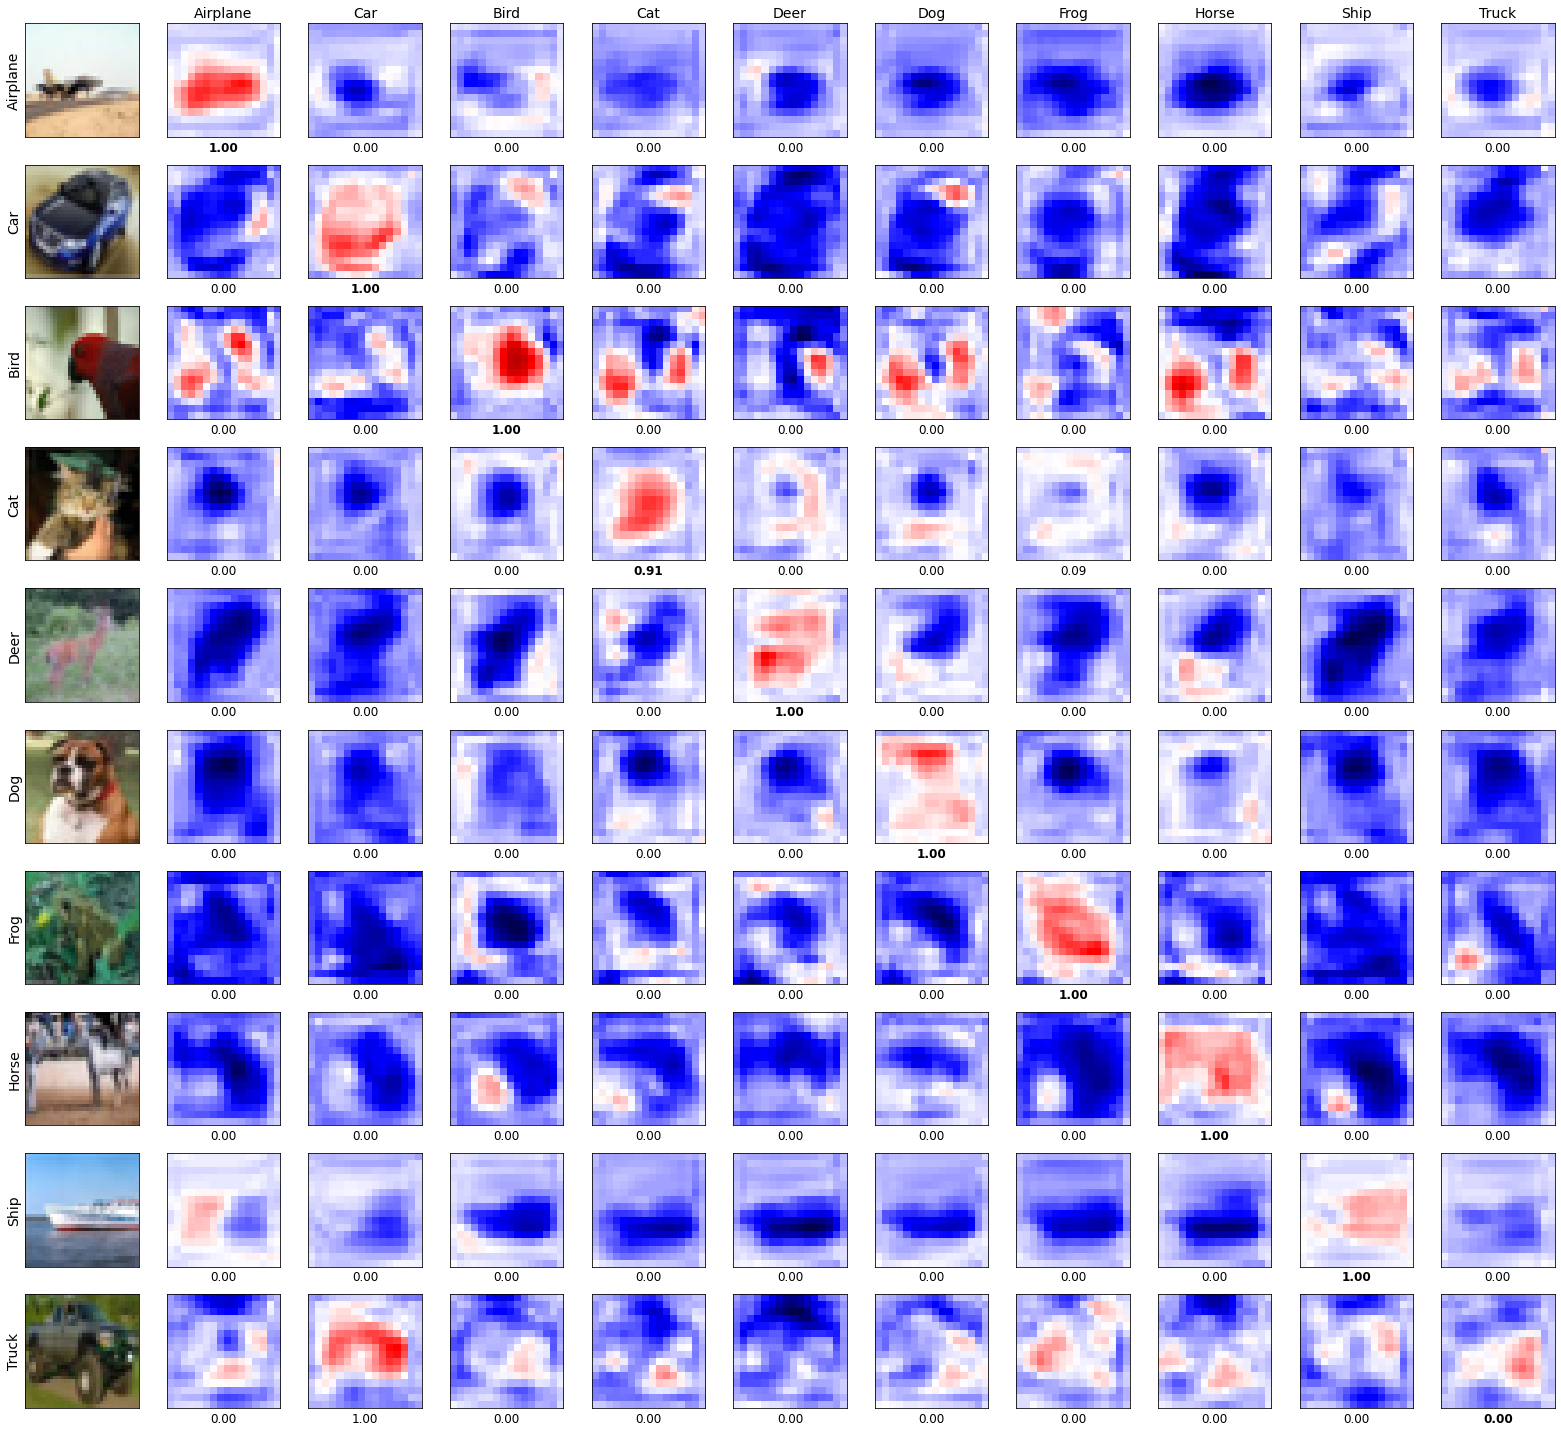

In [24]:
# Select one image from each class
dset = val_set
targets = np.array(dset.targets)
num_classes = targets.max() + 1
inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
x, y = zip(*[dset[ind] for ind in inds])
x = torch.stack(x)

# Get explanations
values = fastshap.shap_values(x.to(device))

# Get predictions
pred = surrogate(
    x.to(device),
    torch.ones(num_classes, surrogate.num_players, device=device)
).softmax(dim=1).cpu().data.numpy()

fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))

for row in range(num_classes):
    # Image
    classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
    std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
    im = x[row].numpy() * std + mean
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    axarr[row, 0].imshow(im, vmin=0, vmax=1)
    axarr[row, 0].set_xticks([])
    axarr[row, 0].set_yticks([])
    axarr[row, 0].set_ylabel('{}'.format(classes[y[row]]), fontsize=14)
    
    # Explanations
    m = np.abs(values[row]).max()
    for col in range(num_classes):
        axarr[row, col + 1].imshow(values[row, col], cmap='seismic', vmin=-m, vmax=m)
        axarr[row, col + 1].set_xticks([])
        axarr[row, col + 1].set_yticks([])
        if col == y[row]:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12, fontweight='bold')
        else:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12)
        
        # Class labels
        if row == 0:
            axarr[row, col + 1].set_title('{}'.format(classes[y[col]]), fontsize=14)

plt.tight_layout()
plt.show()